# Модель прогнозирования спроса
Краткое описание:
<br>Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День.

Задача:
<br>Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных
признаков.

Метрика качества:
<br>`WAPE`:
<br>`def wape(y_true: np.array, y_pred: np.array):`
    <br>`return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))`

### Описание данных
1) sales_df_train.csv –данные по продажам за скользящий год для обучения.
    * Столбцы:
        - st_id – захэшированное id магазина;
        - pr_sku_id – захэшированное id товара;
        - date – дата;
        - pr_sales_type_id – флаг наличия промо;
        - pr_sales_in_units – число проданных товаров всего (промо и без); **описание изменено после уточнения у бизнеса**
        - pr_promo_sales_in_units – число проданных товаров с признаком промо;
        - pr_sales_in_rub – продажи в РУБ всего (промо и без); **описание изменено после уточнения у бизнеса**
        - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
2) pr_df.csv – данные по товарной иерархии.
<br>От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - Столбцы:
        - pr_group_id – захэшированная группа товара;
        - pr_cat_id – захэшированная категория товара;
        - pr_subcat_id – захэшированная подкатегория товара;
        - pr_sku_id – захэшированное id товара;
        - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
3) pr_st.csv – данные по магазинам.
    - Столбцы:
        - st_id – захэшированное id магазина;
        - st_city_id – захэшированное id города;
        - st_division_code id – захэшированное id дивизиона;
        - st_type_format_id – id формата магазина;
        - st_type_loc_id – id тип локации/окружения магазина;
        - st_type_size_id – id типа размера магазина;
        - st_is_active – флаг активного магазина на данный момент.

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

## Знакомство с данными

Пример файла с результатом прогноза

In [ ]:
# sales_submission_ex = pd.read_csv('sp_sales_task/sales_submission.csv')
# sales_submission_ex.head()

In [2]:
pr_df = pd.read_csv('sp_sales_task/pr_df.csv')
pr_st = pd.read_csv('sp_sales_task/st_df.csv')
sales_df = pd.read_csv('sp_sales_task/sales_df_train.csv')

In [3]:
display(pr_df.sample())
pr_df.info()
display(pr_st.sample())
pr_st.info()
display(sales_df.sample())
sales_df.info()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
1514,ced1b276c04d70176ac39aaf5423e19a,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,6639ae8d530e71980239f7bff60e247c,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
215063,16a5cdae362b8d27a1d8f8c7b78b4330,f152516615efd05cf4b4903b03d4a45d,2023-03-06,1,4.0,4.0,483.0,483.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


## Предобработка данных

#### Объединение датафреймов

In [4]:
common_df = sales_df.merge(pr_st, on='st_id', how='left').merge(pr_df, on='pr_sku_id', how='left')
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
400995,c81e728d9d4c2f636f067f89cc14862c,263e163dbb6d251a80e00a4583c9d2d3,2023-02-12,1,2.0,2.0,31.0,31.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
 8   st_city_id               883015 non-null  object 
 9   st_division_code         883015 non-null  object 
 10  st_type_format_id        883015 non-null  int64  
 11  st_type_loc_id           883015 non-null  int64  
 12  st_type_size_id          883015 non-null  int64  
 13  st_is_active             883015 non-null  int64  
 14  pr_g

#### Проверка нулевых значений в количестве

In [5]:
sales_units_zero = common_df[common_df['pr_sales_in_units'] == 0]
print(
    'нулевые продажи в шт и руб:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)
print(
    'нулевые продажи в шт, но не нулевые в рублях:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)
sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0].head()

нулевые продажи в шт и руб: 454 
их доля в данных: 0.05 %
нулевые продажи в шт, но не нулевые в рублях: 66089 
их доля в данных: 7.48 %


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1
6,f7e6c85504ce6e82442c770f7c8606f0,b75c7cbf7accdaea8a1a14781bb29870,2023-02-15,0,0.0,0.0,171.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,1
28,f7e6c85504ce6e82442c770f7c8606f0,88d7313785c97631bf3df61e70636491,2022-11-30,0,0.0,0.0,79.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,567115097ac405a46a84ef641c2d7069,1
32,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2023-02-26,0,0.0,0.0,83.0,0.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,1


**Вывод:** 
- в данных имеются записи, которые можно удалить (их доля 0.05%): нулевые значения в количестве проданных товаров и их стоимости
- записи, по которым требуется уточнение в бизнесе (их доля 7.48%): нулевые значения в количестве проданных товаров и ненулевые в их стоимости.

#### Удаление данных с нулями в количестве

In [6]:
common_df = common_df.loc[common_df['pr_sales_in_units'] != 0]
common_df.info()
common_df.sample()

<class 'pandas.core.frame.DataFrame'>
Index: 816472 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    816472 non-null  object 
 1   pr_sku_id                816472 non-null  object 
 2   date                     816472 non-null  object 
 3   pr_sales_type_id         816472 non-null  int64  
 4   pr_sales_in_units        816472 non-null  float64
 5   pr_promo_sales_in_units  816472 non-null  float64
 6   pr_sales_in_rub          816472 non-null  float64
 7   pr_promo_sales_in_rub    816472 non-null  float64
 8   st_city_id               816472 non-null  object 
 9   st_division_code         816472 non-null  object 
 10  st_type_format_id        816472 non-null  int64  
 11  st_type_loc_id           816472 non-null  int64  
 12  st_type_size_id          816472 non-null  int64  
 13  st_is_active             816472 non-null  int64  
 14  pr_group_

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
538239,6364d3f0f495b6ab9dcf8d3b5c6e0b01,611f825b294117975c8d5c112cfb44ad,2022-11-10,0,1.0,0.0,102.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,4bc94de7bab27a1c3a9cd3ba68199f55,1


#### Количество активных магазинов

In [7]:
print('количество магазинов без маркера активности:', 
      pr_st[pr_st['st_is_active'] == 0]['st_id'].count(), 
      '\nих доля в общем количестве магазинов:', 
      round(pr_st[pr_st['st_is_active'] == 0]['st_id'].count() / pr_st['st_id'].count(), 2)
     )

количество магазинов без маркера активности: 2 
их доля в общем количестве магазинов: 0.17


#### Количество данных по неактивным магазинам

In [8]:
unactive_store_sales = common_df[common_df['st_is_active'] == 0]
print(
    'количество записей по неактивным магазинам:', 
    unactive_store_sales['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(unactive_store_sales['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)

количество записей по неактивным магазинам: 728 
их доля в данных: 0.09 %


**Вывод:** в данных найдены магазины без маркера активности. Возможно, их можно удалить, требуется уточнение у бизнеса.

#### Удаление данных по неактивным магазинам

In [12]:
common_df = common_df.loc[~common_df['st_id'].isin(list(pr_st[pr_st['st_is_active'] == 0]['st_id']))]
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
468053,16a5cdae362b8d27a1d8f8c7b78b4330,4a15a652bde1a9a3ac9cb96160ff3a98,2023-02-24,0,2.0,0.0,262.0,0.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c93c26cd49ea08e6b8984351d4164575,1


<class 'pandas.core.frame.DataFrame'>
Index: 815744 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    815744 non-null  object 
 1   pr_sku_id                815744 non-null  object 
 2   date                     815744 non-null  object 
 3   pr_sales_type_id         815744 non-null  int64  
 4   pr_sales_in_units        815744 non-null  float64
 5   pr_promo_sales_in_units  815744 non-null  float64
 6   pr_sales_in_rub          815744 non-null  float64
 7   pr_promo_sales_in_rub    815744 non-null  float64
 8   st_city_id               815744 non-null  object 
 9   st_division_code         815744 non-null  object 
 10  st_type_format_id        815744 non-null  int64  
 11  st_type_loc_id           815744 non-null  int64  
 12  st_type_size_id          815744 non-null  int64  
 13  st_is_active             815744 non-null  int64  
 14  pr_group_

#### Изменение формата в поле с датами

In [13]:
common_df['date'] = pd.to_datetime(common_df['date'])
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
215853,42a0e188f5033bc65bf8d78622277c4e,1e530dac29b2ea4389130dafa762c7bc,2023-01-30,0,1.0,0.0,131.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,bb44cd485a19a2b227b3ccc473d10302,17


<class 'pandas.core.frame.DataFrame'>
Index: 815744 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815744 non-null  object        
 1   pr_sku_id                815744 non-null  object        
 2   date                     815744 non-null  datetime64[ns]
 3   pr_sales_type_id         815744 non-null  int64         
 4   pr_sales_in_units        815744 non-null  float64       
 5   pr_promo_sales_in_units  815744 non-null  float64       
 6   pr_sales_in_rub          815744 non-null  float64       
 7   pr_promo_sales_in_rub    815744 non-null  float64       
 8   st_city_id               815744 non-null  object        
 9   st_division_code         815744 non-null  object        
 10  st_type_format_id        815744 non-null  int64         
 11  st_type_loc_id           815744 non-null  int64         
 12  st_type_size_id      

#### Сортировка в порядке возрастания

In [20]:
common_df = common_df.sort_values(by='date', ignore_index=True)

#### Анализ целевого признака

Количество записей со значением целевого признака меньше нуля

In [24]:
print(
    'количество записей возвратов:', 
    common_df[common_df['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(), 
    '\nих доля в данных:', 
    round(common_df[common_df['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / common_df['pr_sales_in_units'].count() * 100, 2), '%'
)

количество записей возвратов: 71 
их доля в данных: 0.01 %


Удаление записей возвратов

In [26]:
common_df = common_df.loc[common_df['pr_sales_in_units'] > 0]
common_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815673 entries, 0 to 815743
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815673 non-null  object        
 1   pr_sku_id                815673 non-null  object        
 2   date                     815673 non-null  datetime64[ns]
 3   pr_sales_type_id         815673 non-null  int64         
 4   pr_sales_in_units        815673 non-null  float64       
 5   pr_promo_sales_in_units  815673 non-null  float64       
 6   pr_sales_in_rub          815673 non-null  float64       
 7   pr_promo_sales_in_rub    815673 non-null  float64       
 8   st_city_id               815673 non-null  object        
 9   st_division_code         815673 non-null  object        
 10  st_type_format_id        815673 non-null  int64         
 11  st_type_loc_id           815673 non-null  int64         
 12  st_type_size_id      

In [27]:
common_df['pr_sales_in_units'].describe()

count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

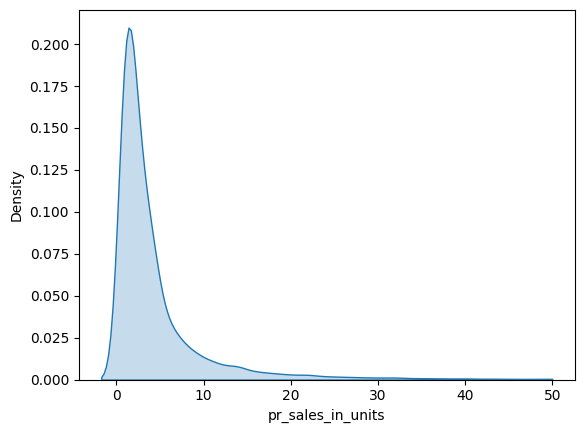

In [56]:
sns.kdeplot(common_df, x='pr_sales_in_units', clip=(-10, 50), fill=True);

**Вывод:** среднее значение больше медианного, наблюдается правосторонняя асимметрия.

#### Тепловая диаграмма для выявления корреляции между признаками

### Выводы
- Данные загружены с распознованием дат.
- Данные предоставлены за период с `01.08.2022` по `18.07.2023`
- Можем удалить признаки, связанные с промо, т.к. они дублируют общие значения
- Можно удалить записи (около 7.5% датасета):
    - с нулевыми значениями в количестве проданных товаров и их стоимости,
    - с нулевыми значениями в количестве проданных товаров и ненулевыми в их стоимости (действие согласовано с бизнесом)
- Можно удалить магазины без маркера активности (действие согласовано с бизнесом):
    - им соответствует 729 записей, что составляет 0.08% датасета

#### Удаление данных, связанных с промо

In [ ]:
sales_dt = sales_dt.drop(['pr_sales_type_id', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub', 'price_difference'], axis=1)
sales_dt.head()

#### Импорт календаря РФ

In [ ]:
calendar = pd.read_csv('holidays_covid_calendar.csv')
calendar.info()
calendar.sample()

## Чек-лист
1. Файл в зафиксированном формате с результатом прогноза спроса (sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    
    a. Описание обученной модели прогноза спроса
    
        i. Признаки
        ii. интерпретация (shapley values),
        iii. кросс-валидация
        iv. алгоритмы
    
    b. Описание вашего алгоритма оптимизации:
    
        i. методология расчетов
        ii. скорость оптимизации